<h1>Levenberg-Marquardt Algorithm Tensorflow Based Implementation</h1>
<h2>Introduction</h2>
The Levenberg-Marquardt (LM) algorithm is the most widely used optimization algorithm. It outperforms simple gradient descent and other conjugate gradient methods in a wide variety of problems. This tutorial demonstrates LM implementation using Tensorflow to optimize MLP neural networks.
<h2>Imports</h2>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
%matplotlib inline

/home/andrey/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h2>Rosenbrock function</h2>
We will use Rosenbrock function as performance test problem. Let's start with its two variables form: <i>f(x, y) = (a - x)^2 + b(y - x^2)^2</i>.

In [2]:
def rosenbrock(x, y, a, b):
    return (a - x)**2 + b*(y - x**2)**2

# consider this function on the square [-2,2]x[-2,2]
x_grid, y_grid = np.meshgrid(np.arange(-2, 2.1, 0.1), 
                             np.arange(-2, 2.1, 0.1))
# with parameters a = 0.5 and b = 0.5
z_grid = rosenbrock(x_grid, y_grid, 0.5, 0.5)

<h2>Helper-function for plotting images</h2>

In [3]:
GRAY1 = '#646369'
BLUE1, BLUE2 = '#4A81BF', '#174A7E'

def prepare_3d_plot_for_rosenbrock():
    fig = plt.figure(figsize=(7, 5), dpi=110)
    ax = fig.add_subplot(111, projection='3d')
    # configure tick labels appearance
    for i in ax.get_yticklabels() + ax.get_xticklabels() + ax.get_zticklabels():
        i.set_fontsize(8)
        i.set_color(GRAY1)
    ax.view_init(40, 80)
    return ax

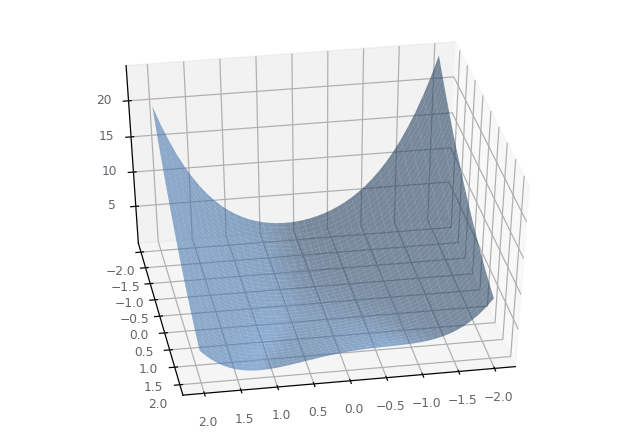

In [4]:
# let's plot it
ax = prepare_3d_plot_for_rosenbrock()
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.6, color=BLUE1)

<h2>The Problem</h2>
The problem for which the LM algorithm provides a solution is called <i>Nonlinear Least Squares Minimization</i>. Suppose from an experiment we have as set of <i>m</i> data points, <i>(x1, y1, z1), (x2, y2, z2),..., (xm, ym, zm)</i>. Our goal is to be able to predict <i>z</i> for other values <i>(x, y)</i>. We have a model function <i>z = rosenbrock(x, y, a, b)</i>, that in addition to the variables <i>(x, y)</i> also depends on parameters <i>a, b</i>. It is desired to find these parameters such that the surface fits best the given data in the least squares sense.

In [19]:
# generate some data points from an "experiment"
data_points = np.array([[x, y, rosenbrock(x, y, 0.5, 0.5)]
                       for x in np.arange(-2, 2.1, 2) 
                       for y in np.arange(-2, 2.1, 2)])
m = data_points.shape[0]

# now, please, forget about actual paramenters (0.5, 0.5)
# suppose they are unknown and our goal is to estimate them 
# using only data_points and knowledge about our model

# we start with guessing
a_guess, b_guess = 5, 5
# predictions usually have -hat suffix
z_hat = rosenbrock(data_points[:,0], data_points[:,1], a_guess, b_guess)
# residual is the difference between the measured value and the predicted value
r = data_points[:,2] - z_hat
# calculate the squared residuals sum in one line of code
# by multiplying a row vectory by itself column vector
loss = r.dot(r.T)/m
# our guess is bad :(. Let's try another guess?
print(loss)

10926.5625


<h2>The Problem Graphical Representation</h2>
We can plot the data points from the experiment as dots, our model as a suface and the residuals as lines connecting data dots to the model surface. See how far the data points are from the model. We need to find better <i>a, b</i> to make it closer.

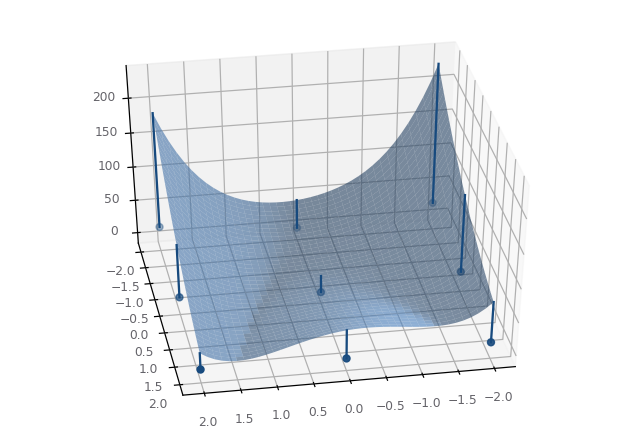

In [9]:
ax = prepare_3d_plot_for_rosenbrock()
# plot data points from an experiment
ax.scatter(data_points[:,0], 
           data_points[:,1], 
           data_points[:,2], 
           color=BLUE2)
# plot our model surface 
z_hat_grid = rosenbrock(x_grid, y_grid, a_guess, b_guess)
ax.plot_surface(x_grid, y_grid, z_hat_grid, alpha=0.6, color=BLUE1)
# plot residuals as lines
for i in range(m):
    ax.plot([data_points[i, 0], data_points[i, 0]], 
            [data_points[i, 1], data_points[i, 1]], 
            [data_points[i, 2], z_hat[i]], c=BLUE2)

<h2>Tensorflow Problem Definition</h2>
From now let's start using more common convention for naming. Instead of <i>z = f(x, y, a, b)</i> we'll use <i>y = f(x, a, b)</i>, where <i>x</i> is vector. In the case of 2D rosenbrock it is a vector of 2. On the next step we'll construct so-called computational graph. Please, note that no actual computation is performed.

In [21]:
# placeholder variables (we have m data points)
x = tf.placeholder(tf.float32, shape=[m, 2])
y = tf.placeholder(tf.float32, shape=[m])

# variables to be optimized with initial guess
a = tf.Variable(a_guess, dtype=tf.float32)
b = tf.Variable(b_guess, dtype=tf.float32)

# model 
x1, x2 = x[:, 0], x[:, 1]
y_hat = (a - x1)**2 + b*(x2 - x1**2)**2

#cost-function to be optimized
loss = tf.reduce_mean(tf.square(y - y_hat))

In [22]:
# construct so-called feed dictionary to map placeholders to actual values
feed_dict = {x: data_points[:,0:2], y: data_points[:,2]}

<h2>TensorFlow Run</h2>

In [118]:
# create TensorFlow session
session = tf.Session()
# initialize variables
session.run(tf.global_variables_initializer())
# calculate loss using tensorflow  if everything is correct, 
# the loss equals to the previously calcualted by means of numpy
current_loss = session.run(loss, feed_dict)
print(current_loss)

10926.5625


<h2>Optimization method</h2>
Now that we have a model and a loss measure that must be minimized, we can then create an optimizer. Levenberg-Marquardt is a mixture of Newton-Gauss and a basic form of Gradient Descent. Let's start with Gradient Descent. There is an easy way to create an optimizer, but let's do some more work and implement it ourselves.

In [119]:
# create an optimizer object
opt = tf.train.GradientDescentOptimizer(learning_rate=1)

# calculate the partial derivatives of the loss function with respect to a and b
a_grad, b_grad = tf.gradients(loss, [a, b])

# set the learning rate 
learning_rate = 0.0005
a_grad, b_grad = a_grad*learning_rate, b_grad*learning_rate

# define the SGD step
sgd = opt.apply_gradients([(a_grad, a), (b_grad, b)])

In [112]:
step = 0
while current_loss > 0.001:
    step += 1
    session.run(sgd, feed_dict)
    current_loss = session.run(loss, feed_dict)
    if step % 100 == 0:
        print('step: ', step, 'current loss: ', current_loss)
print('step: ', step, 'current loss: ', current_loss)

step:  0 current loss:  0.0009803904


In [120]:
y_hat_flat = tf.reshape(y_hat, (-1,))
j = tf.stack([tf.gradients(y_i, [a, b]) 
              for y_i in tf.unstack(y_hat_flat)])
jT = tf.transpose(j)
r = tf.reshape(y - y_hat, [m, 1])
f = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(jT, j)), jT), r)
grad_a, grad_b = tf.unstack(f)
train_step = opt.apply_gradients([(-grad_a[0], a), (-grad_b[0], b)])

In [127]:
session.run(train_step, feed_dict)

In [128]:
session.run(loss, feed_dict)

6.4239536e-10